# AlphaNetPro

## Import packages

In [1]:
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from itertools import combinations

import functools

In [2]:
tf.__version__

'2.5.0'

In [3]:
shap.__version__

'0.39.0'

In [4]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

shap.initjs()

Instructions for updating:
non-resource variables are not supported in the long term


## Create synthetic data

In [5]:
ndays = 300  # Number of days
nfeats = 5   # Number of features

raw_data = dict()
maxlen = len(str(ndays - 1))
for i in range(ndays):
    key = 'T' + f'{i}'.zfill(maxlen)
    raw_data[key] = np.random.random(nfeats)
features = [f'F{i}' for i in range(nfeats)]

df = pd.DataFrame(raw_data, index=features)

In [6]:
df

,T000,T001,T002,T003,T004,T005,T006,T007,T008,T009,...,T290,T291,T292,T293,T294,T295,T296,T297,T298,T299
F0,0.083625,0.734910,0.238833,0.749532,0.106571,0.936059,0.310386,0.599922,0.350142,0.077634,...,0.671257,0.980523,0.925962,0.098301,0.534093,0.745261,0.729240,0.417559,0.909972,0.988006
F1,0.693948,0.320072,0.106895,0.173432,0.884216,0.595251,0.806779,0.713424,0.896936,0.430448,...,0.522611,0.654811,0.965330,0.714292,0.617742,0.741673,0.652427,0.093923,0.718615,0.327414
F2,0.478280,0.715890,0.535852,0.466307,0.391894,0.679154,0.005853,0.338275,0.256867,0.004298,...,0.636192,0.121086,0.555896,0.569837,0.701893,0.239643,0.466669,0.842518,0.825526,0.053318
F3,0.903568,0.236947,0.205568,0.658991,0.813554,0.858507,0.748958,0.055797,0.048620,0.823834,...,0.938741,0.176166,0.382360,0.297384,0.058629,0.513993,0.389428,0.364102,0.745239,0.137298
F4,0.907833,0.993881,0.736457,0.462007,0.177163,0.968737,0.586325,0.003427,0.576098,0.023146,...,0.906170,0.025858,0.646583,0.779058,0.535283,0.732658,0.732806,0.507432,0.796668,0.568747


## Function to Generate Samples

In [7]:
# rtdays=5 means the target value would be the 5-day return
def generate_samples(data, rtdays=5, width=30, strides=1):
    dates = []
    samples = []
    targets = []
    
    i = data.shape[1] - 1 - rtdays
    
    while i - width + 1 >= 0:
        rt = (data.iloc[-1,i+rtdays] - data.iloc[-1,i]) / data.iloc[-1,i]
        
        dates.append(data.columns[i])
        samples.append(data.iloc[:,i-width+1:i+1])
        targets.append(rt)
        
        i -= strides
    
    dates.reverse()
    samples.reverse()
    targets.reverse()
    
    return dates, samples, targets

In [8]:
dates, samples, targets = generate_samples(df, strides=2)

In [9]:
len(dates)

133

In [10]:
len(samples)

133

In [11]:
len(targets)

133

In [12]:
dates[:10]

['T030',
 'T032',
 'T034',
 'T036',
 'T038',
 'T040',
 'T042',
 'T044',
 'T046',
 'T048']

In [13]:
dates[-10:]

['T276',
 'T278',
 'T280',
 'T282',
 'T284',
 'T286',
 'T288',
 'T290',
 'T292',
 'T294']

In [14]:
samples[0]

,T001,T002,T003,T004,T005,T006,T007,T008,T009,T010,...,T021,T022,T023,T024,T025,T026,T027,T028,T029,T030
F0,0.734910,0.238833,0.749532,0.106571,0.936059,0.310386,0.599922,0.350142,0.077634,0.928230,...,0.089617,0.510592,0.014020,0.670637,0.832857,0.159490,0.295799,0.804171,0.338648,0.937011
F1,0.320072,0.106895,0.173432,0.884216,0.595251,0.806779,0.713424,0.896936,0.430448,0.700874,...,0.623742,0.318510,0.400781,0.288683,0.901434,0.165340,0.227768,0.767047,0.624595,0.508399
F2,0.715890,0.535852,0.466307,0.391894,0.679154,0.005853,0.338275,0.256867,0.004298,0.992361,...,0.451658,0.914777,0.087909,0.287573,0.739569,0.879791,0.831139,0.231422,0.853054,0.178619
F3,0.236947,0.205568,0.658991,0.813554,0.858507,0.748958,0.055797,0.048620,0.823834,0.306866,...,0.517147,0.362559,0.644911,0.640825,0.581332,0.271132,0.696700,0.845539,0.653080,0.959715
F4,0.993881,0.736457,0.462007,0.177163,0.968737,0.586325,0.003427,0.576098,0.023146,0.589145,...,0.856018,0.579661,0.674286,0.287708,0.936507,0.053231,0.666625,0.113539,0.083372,0.292776


In [15]:
samples[-1]

,T265,T266,T267,T268,T269,T270,T271,T272,T273,T274,...,T285,T286,T287,T288,T289,T290,T291,T292,T293,T294
F0,0.236747,0.274922,0.309971,0.149504,0.279339,0.242234,0.535525,0.604120,0.877899,0.190934,...,0.836721,0.146849,0.037930,0.129658,0.520189,0.671257,0.980523,0.925962,0.098301,0.534093
F1,0.505678,0.161018,0.726950,0.608101,0.143730,0.800986,0.342570,0.873262,0.160856,0.068292,...,0.173614,0.653815,0.019062,0.362210,0.653560,0.522611,0.654811,0.965330,0.714292,0.617742
F2,0.745143,0.716290,0.120568,0.233259,0.149853,0.986951,0.494547,0.064493,0.173181,0.737485,...,0.418701,0.579849,0.830999,0.235837,0.420304,0.636192,0.121086,0.555896,0.569837,0.701893
F3,0.856627,0.568196,0.686328,0.638484,0.422373,0.717738,0.293630,0.456236,0.758706,0.554483,...,0.518219,0.464133,0.551420,0.736017,0.761765,0.938741,0.176166,0.382360,0.297384,0.058629
F4,0.643324,0.313610,0.568067,0.357347,0.437407,0.961250,0.745378,0.793601,0.492116,0.426850,...,0.633245,0.843070,0.698939,0.758967,0.006226,0.906170,0.025858,0.646583,0.779058,0.535283


In [16]:
targets[0]

0.5174760517414017

In [17]:
targets[-1]

0.06251535665040088

In [18]:
train_data = np.array(samples[:100], dtype='float32')
test_data = np.array(samples[100:], dtype='float32')
train_targets = np.array(targets[:100], dtype='float32')
test_targets = np.array(targets[100:], dtype='float32')

## Feature Extraction Functions

In [19]:
def ts_corr(X, Y, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        Ysub = Y[i-d+1:i+1]
        corr = np.corrcoef(Xsub, Ysub)[0,1]
        res.append(corr)
        
        i -= s

    return np.array(res, dtype='float32')

In [20]:
def ts_cov(X, Y, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        Ysub = Y[i-d+1:i+1]
        cov = np.cov(Xsub, Ysub)[0,1]
        res.append(cov)
        
        i -= s
        
    return np.array(res, dtype='float32')

In [21]:
def ts_stdev(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        stdev = np.std(Xsub)
        res.append(stdev)
        
        i -= s
        
    return np.array(res, dtype='float32')

In [22]:
def ts_zscore(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        zscore = np.mean(Xsub) / np.std(Xsub)
        res.append(zscore)
        
        i -= s
        
    return np.array(res, dtype='float32')

In [23]:
def ts_return(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        ret = (Xsub[-1] - Xsub[0]) / Xsub[0]
        res.append(ret)
        
        i -= s
        
    return np.array(res, dtype='float32')

In [24]:
def ts_decaylinear(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        Wsub = np.array([i for i in range(1, d+1)])
        weighted_sum = np.sum(Xsub * Wsub / np.sum(Wsub))
        res.append(weighted_sum)
        
        i -= s
        
    return np.array(res, dtype='float32')

In [25]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([6, 7, 8, 9, 10])

In [26]:
ts_corr(a, b, d=3, s=3)

array([1.], dtype=float32)

In [27]:
ts_cov(a, b, d=3, s=3)

array([1.], dtype=float32)

In [28]:
ts_stdev(a, d=3, s=3)

array([0.8164966], dtype=float32)

In [29]:
ts_zscore(a, d=3, s=3)

array([4.8989797], dtype=float32)

In [30]:
ts_return(a, d=3, s=3)

array([0.6666667], dtype=float32)

In [31]:
ts_decaylinear(a, d=3, s=3)

array([4.3333335], dtype=float32)

## Pooling Functions

In [32]:
def ts_min(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        vmin = tf.math.reduce_min(Xsub)
        res.append(vmin)
        i -= s
    
    res.reverse()
    
    return tf.convert_to_tensor(res)

In [33]:
def ts_max(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        vmax = tf.math.reduce_max(Xsub)
        res.append(vmax)
        i -= s
        
    res.reverse()
    
    return tf.convert_to_tensor(res)

In [34]:
def ts_mean(X, d=2, s=1):
    res = []
    i = len(X) - 1
    
    while i - d + 1 >= 0:
        Xsub = X[i-d+1:i+1]
        vmean = tf.math.reduce_mean(Xsub)
        res.append(vmean)
        i -= s
        
    res.reverse()
    
    return tf.convert_to_tensor(res)

## Function to Generate Synthetic Features

In [35]:
def generate_syn_feats(feats, fn_names):
    syn_feats = []
    
    for fn in fn_names:
        if fn in ['ts_corr', 'ts_cov']:
            for r1, r2 in combinations(range(len(feats)), 2):
                f1 = feats[r1]
                f2 = feats[r2]
                syn_feats.append(f"N({fn}({f1},{f2}))")
        else:
            for feat in feats:
                syn_feats.append(f"N({fn}({feat}))")
    
    return syn_feats

In [36]:
syn_feats = generate_syn_feats(
    features,
    ["ts_corr", "ts_cov", "ts_stdev", "ts_zscore", "ts_return", "ts_decaylinear"]
)

In [37]:
syn_feats

['N(ts_corr(F0,F1))',
 'N(ts_corr(F0,F2))',
 'N(ts_corr(F0,F3))',
 'N(ts_corr(F0,F4))',
 'N(ts_corr(F1,F2))',
 'N(ts_corr(F1,F3))',
 'N(ts_corr(F1,F4))',
 'N(ts_corr(F2,F3))',
 'N(ts_corr(F2,F4))',
 'N(ts_corr(F3,F4))',
 'N(ts_cov(F0,F1))',
 'N(ts_cov(F0,F2))',
 'N(ts_cov(F0,F3))',
 'N(ts_cov(F0,F4))',
 'N(ts_cov(F1,F2))',
 'N(ts_cov(F1,F3))',
 'N(ts_cov(F1,F4))',
 'N(ts_cov(F2,F3))',
 'N(ts_cov(F2,F4))',
 'N(ts_cov(F3,F4))',
 'N(ts_stdev(F0))',
 'N(ts_stdev(F1))',
 'N(ts_stdev(F2))',
 'N(ts_stdev(F3))',
 'N(ts_stdev(F4))',
 'N(ts_zscore(F0))',
 'N(ts_zscore(F1))',
 'N(ts_zscore(F2))',
 'N(ts_zscore(F3))',
 'N(ts_zscore(F4))',
 'N(ts_return(F0))',
 'N(ts_return(F1))',
 'N(ts_return(F2))',
 'N(ts_return(F3))',
 'N(ts_return(F4))',
 'N(ts_decaylinear(F0))',
 'N(ts_decaylinear(F1))',
 'N(ts_decaylinear(F2))',
 'N(ts_decaylinear(F3))',
 'N(ts_decaylinear(F4))']

In [38]:
len(syn_feats)

40

## Function to Generate Synthetic Samples

In [39]:
def generate_syn_samples(train_data, test_data, width=2, strides=1):
    feomap = { 'train': [], 'test': [] }
    fefns = (ts_corr, ts_cov, ts_stdev, ts_zscore, ts_return, ts_decaylinear)
    nfeats = train_data[0].shape[0]
    
    for sample in train_data:
        feoutput = []
        
        for fefn in fefns:
            if fefn in [ts_corr, ts_cov]:
                for r1, r2 in combinations(range(nfeats), 2):
                    res = fefn(sample[r1], sample[r2], d=width, s=strides)
                    feoutput.append(res)
            else:
                for row in sample:
                    res = fefn(row, d=width, s=strides)
                    feoutput.append(res)
                    
        feomap['train'].append(feoutput)
        
    for sample in test_data:
        feoutput = []
        
        for fefn in fefns:
            if fefn in [ts_corr, ts_cov]:
                for r1, r2 in combinations(range(nfeats), 2):
                    res = fefn(sample[r1], sample[r2], d=width, s=strides)
                    feoutput.append(res)
            else:
                for row in sample:
                    res = fefn(row, d=width, s=strides)
                    feoutput.append(res)
                    
        feomap['test'].append(feoutput)
    
    feomap['train'] = np.array(feomap['train'], dtype='float32')
    feomap['test'] = np.array(feomap['test'], dtype='float32')
    
    # Normalize
    nrows, ncols = feomap['train'][0].shape
    
    for i in range(nrows):
        for j in range(ncols):
            arr = []
            
            for sample in feomap['train']:
                arr.append(sample[i,j])
                
            arr_mean = np.mean(arr)
            arr_stdev = np.std(arr)
            
            for sample in feomap['train']:
                sample[i,j] = (sample[i,j] - arr_mean) / arr_stdev
                
            for sample in feomap['test']:
                sample[i,j] = (sample[i,j] - arr_mean) / arr_stdev

    return feomap

In [40]:
syn_samples_dict = generate_syn_samples(train_data, test_data, width=3, strides=3)

In [41]:
syn_samples_dict['train'].shape

(100, 40, 10)

In [42]:
syn_samples_dict['test'].shape

(33, 40, 10)

In [43]:
syn_train_data = syn_samples_dict['train']
syn_test_data = syn_samples_dict['test']

In [44]:
syn_train_data.shape

(100, 40, 10)

In [45]:
syn_train_targets = train_targets
syn_test_targets = test_targets

In [46]:
syn_train_targets.shape

(100,)

In [47]:
syn_test_targets.shape

(33,)

In [48]:
model = models.Sequential()

model.add(layers.Input(shape=(40, 10)))

model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu',
                       kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.fit(syn_train_data, syn_train_targets, epochs=20, batch_size=32, verbose=0)

2021-07-04 16:58:45.592023: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.evaluate(syn_test_data, syn_test_targets)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


[4384.285261674361, 30.632208]

In [51]:
shap_dexp = shap.DeepExplainer(model, syn_train_data)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [52]:
# 1 x number of samples x number of features x number of days

# sample1 + sample2 + ... + 

shap_values = shap_dexp.shap_values(syn_test_data)

shap_values = shap_values[0]
shap_values = np.hstack(shap_values)
shap_values = np.transpose(shap_values)

In [53]:
shap_values.shape

(330, 40)

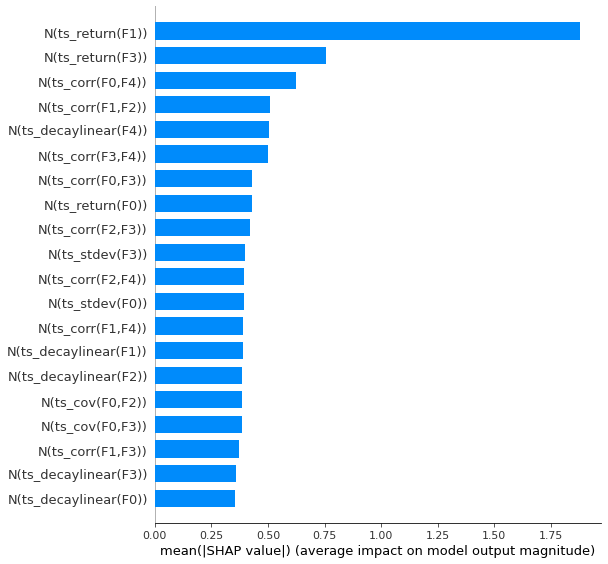

In [54]:
shap.summary_plot(shap_values, features=syn_test_data, feature_names=syn_feats, plot_type='bar')

In [55]:
X_test = np.hstack(syn_test_data)
X_test = np.transpose(X_test)
X_test_df = pd.DataFrame(X_test, columns=syn_feats)

In [56]:
X_test_df

,"N(ts_corr(F0,F1))","N(ts_corr(F0,F2))","N(ts_corr(F0,F3))","N(ts_corr(F0,F4))","N(ts_corr(F1,F2))","N(ts_corr(F1,F3))","N(ts_corr(F1,F4))","N(ts_corr(F2,F3))","N(ts_corr(F2,F4))","N(ts_corr(F3,F4))",...,N(ts_return(F0)),N(ts_return(F1)),N(ts_return(F2)),N(ts_return(F3)),N(ts_return(F4)),N(ts_decaylinear(F0)),N(ts_decaylinear(F1)),N(ts_decaylinear(F2)),N(ts_decaylinear(F3)),N(ts_decaylinear(F4))
0,-0.469687,-1.404883,-0.955372,1.272567,0.757414,1.326612,-0.746146,0.981584,-1.660712,-1.146101,...,-0.393813,-0.107163,-0.080067,-0.256424,-0.259069,-0.288962,1.518647,1.005046,1.692042,1.234361
1,1.425468,0.888618,-1.372253,-0.775784,0.676892,-1.038600,-0.200521,-1.190344,-1.686908,0.979277,...,-0.690988,-0.272386,-0.419258,1.835505,-0.275538,-0.778481,-0.420444,-1.367549,-0.168237,1.095919
2,1.158985,0.210029,-1.723802,0.946456,1.011898,-1.251974,1.613079,-0.303001,0.979526,-1.113788,...,0.693603,282.316101,-0.128866,-0.378743,-0.214704,1.272864,-0.575894,-0.202746,-1.185653,-1.030634
3,-0.254268,-1.294340,1.204189,-0.631613,-0.367906,-0.882725,-1.217386,-0.638150,0.731864,0.288681,...,0.693748,-0.285901,-0.295539,-0.266522,-0.007991,-1.371729,-0.428186,-0.825126,2.513951,-1.121393
4,1.418364,-0.176645,1.115390,-0.093487,0.198859,1.252737,0.487662,0.633626,1.326549,0.660583,...,0.015158,0.487128,-0.121345,6.039972,-0.171037,1.562981,1.316615,1.194402,0.520906,0.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-1.211185,0.994429,-0.000542,-0.529011,-0.315451,-0.773041,-0.569721,-0.816129,-1.374951,1.342483,...,-0.333873,-0.036678,-0.333051,-0.467650,-0.350239,-1.497288,-0.562242,-0.008982,0.750371,-0.318245
326,-0.692324,-1.054236,1.376934,1.296951,-0.252843,-0.695058,-0.847485,-1.059997,-0.917976,1.200070,...,-0.456694,1.807557,-0.163042,-0.306515,-0.261715,-0.686377,-0.291712,-0.712427,0.665926,-0.388304
327,-0.868746,-0.742810,1.398777,-1.601176,-0.713234,-0.446443,1.104906,-0.695048,-0.055372,-1.261513,...,-0.127200,-0.250958,-0.271827,0.389816,-0.402800,1.367993,-0.487022,-1.922110,0.350288,0.774723
328,-0.645221,0.106148,-0.931596,0.401162,1.203139,1.358063,1.127711,1.061371,1.358916,0.752739,...,-0.164989,-0.156839,-0.047201,-0.278491,-0.041332,-1.340624,0.177514,0.438643,0.531402,1.113049


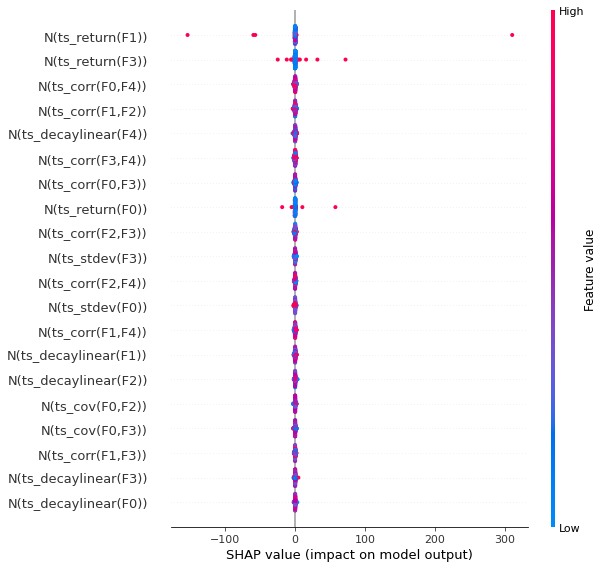

In [57]:
shap.summary_plot(shap_values, X_test, feature_names=syn_feats)

In [58]:
shap_values.shape

(330, 40)

## Define Custom Pooling Layers

In [59]:
class TSPoolLayer(layers.Layer):
    def __init__(self, pool_func, width, strides, name=None):
        super(TSPoolLayer, self).__init__()
        self.pool_func = pool_func
        self.width = width
        self.strides = strides
        self._name = name
        
    def build(self, input_shape):
        super(TSPoolLayer, self).build(input_shape)
        
    def call(self, x):
        n_feats = x.shape[1]
        result = [self.pool_func(x[i], self.width, self.strides) for i in range(n_feats)]
        return tf.convert_to_tensor(result, dtype='float32')

## Define MinPooling1D Layer

In [60]:
class MinPooling1D(layers.MaxPooling1D):
    def __init__(self, pool_size=2, strides=None, padding='valid', data_format='channels_last', **kwargs):
        super(MinPooling1D, self).__init__(
            pool_size=pool_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            **kwargs)
        
    def pooling_function(inputs, pool_size, strides, padding, data_format):
        return -K.pool1d(-inputs, pool_size, strides, padding, data_format, pool_mode='max')

## Define AlphaNet Model

In [61]:
K.clear_session()

model_input = layers.Input(shape=(syn_train_data.shape[-2],
                                 syn_train_data.shape[-1]), dtype='float32', name='input')
input_flattened = layers.Flatten(name='input_flat')(model_input)

#mean3_pooling_layer = TSPoolLayer(ts_mean, 3, 1, name='mean3')(model_input)
mean3_pooling_layer = layers.AveragePooling1D(3, name='mean3')(model_input)
mean3_bn_layer = layers.BatchNormalization(axis=1, name='mean3_bn')(mean3_pooling_layer)
mean3_bn_flattened = layers.Flatten(name='mean3_bn_flat')(mean3_bn_layer)

#max3_pooling_layer = TSPoolLayer(ts_max, 3, 1, name='max3')(model_input)
max3_pooling_layer = layers.MaxPooling1D(3, name='max3')(model_input)
max3_bn_layer = layers.BatchNormalization(axis=1, name='max3_bn')(max3_pooling_layer)
max3_bn_flattened = layers.Flatten(name='max3_bn_flat')(max3_bn_layer)

# min3_pooling_layer = TSPoolLayer(ts_min, 3, 1, name='min3')(model_input)
min3_pooling_layer = MinPooling1D(3, name='min3')(model_input)
min3_bn_layer = layers.BatchNormalization(axis=1, name='min3_bn')(min3_pooling_layer)
min3_bn_flattened = layers.Flatten(name='min3_bn_flat')(min3_bn_layer)

concatenated = layers.concatenate([
    input_flattened, \
    mean3_bn_flattened, \
    max3_bn_flattened, \
    min3_bn_flattened], name='concat')

dense_layer = layers.Dense(30, activation='relu',
                       kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), \
                           name='dense')(concatenated)

dropout_layer = layers.Dropout(0.5, name='dropout')(dense_layer)

model_output = layers.Dense(1, name='output')(dropout_layer)

model = models.Model(model_input, model_output)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40, 10)]     0                                            
__________________________________________________________________________________________________
mean3 (AveragePooling1D)        (None, 13, 10)       0           input[0][0]                      
__________________________________________________________________________________________________
max3 (MaxPooling1D)             (None, 13, 10)       0           input[0][0]                      
__________________________________________________________________________________________________
min3 (MinPooling1D)             (None, 13, 10)       0           input[0][0]                      
______________________

In [62]:
model.fit(syn_train_data, syn_train_targets, epochs=20, batch_size=32, verbose=0)

In [63]:
model.evaluate(syn_test_data, syn_test_targets)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


[6237.834372953935, 42.462833]

In [64]:
shap_dexp = shap.DeepExplainer(model, syn_train_data)

shap_values = shap_dexp.shap_values(syn_test_data)

shap_values = shap_values[0]
shap_values = np.hstack(shap_values)
shap_values = np.transpose(shap_values)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


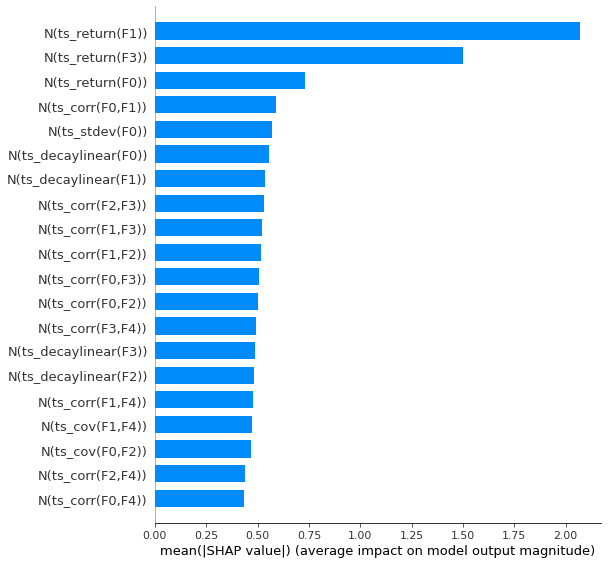

In [65]:
shap.summary_plot(shap_values, features=syn_test_data, feature_names=syn_feats, plot_type='bar')

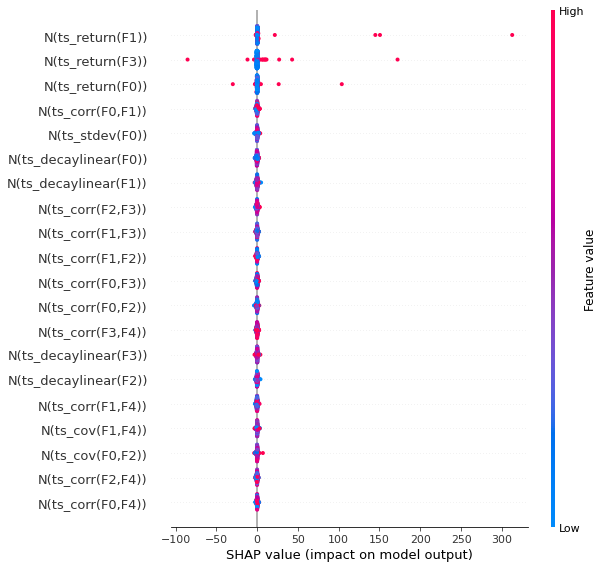

In [66]:
shap.summary_plot(shap_values, X_test, feature_names=syn_feats)